# NYC Green Taxi Data Science Challenge
#### Name: Gloria Gao, 2017 Sep
<a id='introduction'></a>
## Introduction
This coding challenge is designed to test your skill and intuition about real world data. For the challenge, we will use data collected by the New York City Taxi and Limousine commission about "Green" Taxis. Green Taxis (as opposed to yellow ones) are taxis that are not allowed to pick up passengers inside of the densely populated areas of Manhattan. We will use the data from September 2015. We are using NYC Taxi and Limousine trip record data: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).



### [Question 1](#question1)
> * Programmatically download and load into your favorite analytical tool the trip data for September 2015.
> * Report how many rows and columns of data you have loaded.

### [Question 2](#question2)
> * Plot a histogram of the number of the trip distance ("Trip Distance").
> * Report any structure you find and any hypotheses you have about that structure.

### [Question 3](#question3)
> * Report mean and median trip distance grouped by hour of day.
> * We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

### [Question 4](#question4)
> * Build a derived variable for tip as a percentage of the total fare.
> * Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

### [Question 5](#question5)
- Choose only one of these options to answer for Question 5. There is no preference as to which one you choose. Please select the question that you feel your particular skills and/or expertise are best suited to. If you answer more than one, only the first will be scored.
- Option A: Distributions
> * Build a derived variable representing the average speed over the course of a trip.
> * Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?
> * Can you build up a hypothesis of average trip speed as a function of time of day?

In [1]:
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #pretty print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

<a id='question1'></a>
## Question 1
[*Return to Introduction*](#introduction)

> * Programmatically download and load into your favorite analytical tool the trip data for September 2015. 
> * Report how many rows and columns of data you have loaded.

### Acquire and load data


In [2]:
# Download the 'green_tripdata_2015-09' 
base_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
filename = 'green_tripdata_2015-09'


if os.path.exists('green_tripdata_201509.csv'): # if the dataset is present on local path and load it
    df = pd.read_csv('green_tripdata_201509.csv')
else: # Download dataset if not available on current path
    the_url = base_url + filename + '.csv'
    df = pd.read_csv(the_url)
    df.to_csv(the_url.split('/')[-1])

# Print the shape of the dataset
print("Num of Rows is {} and Num of Columns is {}.".format(df.shape[0], df.shape[1]))


Num of Rows is 1494926 and Num of Columns is 21.


<a id='question2'></a>
## Question 2
[*Return to Introduction*](#introduction)
> * Plot a histogram of the number of the trip distance ("Trip Distance").
> * Report any structure you find and any hypotheses you have about that structure.

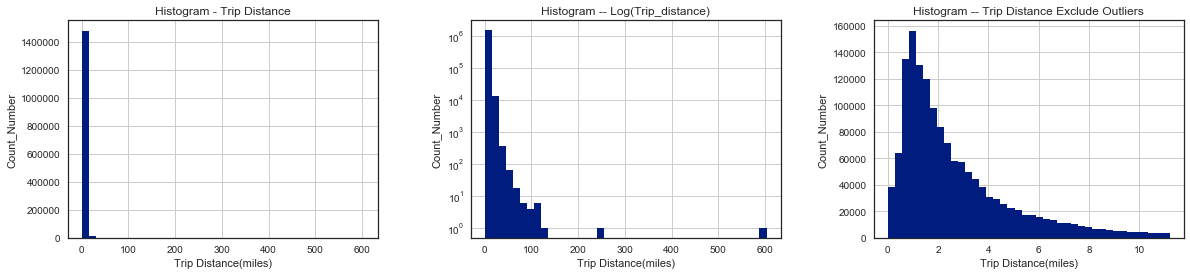

In [3]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')
n_bins = 40

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,4)) 
trip_dist = df[['Trip_distance']]

ax = ax1
trip_dist.hist(bins = n_bins, ax=ax)

ax.set_xlabel('Trip Distance(miles)')
ax.set_ylabel('Count_Number')
ax.set_title('Histogram - Trip Distance')

ax = ax2
trip_dist.hist(bins = n_bins, ax=ax)

ax.set_xlabel('Trip Distance(miles)')
ax.set_ylabel('Count_Number')
ax.set_yscale('log')
ax.set_title('Histogram -- Log(Trip_distance)')


ax = ax3
trip_dist_3sigma = trip_dist[~((trip_dist-trip_dist.median()).abs()>3*trip_dist.std())]
trip_dist_3sigma.hist(bins = n_bins ,ax=ax) # 
ax.set_xlabel('Trip Distance(miles)')
ax.set_ylabel('Count_Number')
ax.set_title('Histogram -- Trip Distance Exclude Outliers')
plt.savefig('fig1_q2.jpeg',format='jpeg')


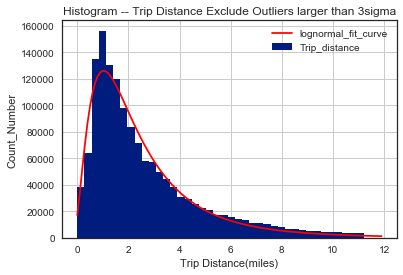

In [6]:
# define the figure with 1 plot
n_bins = 40
f, ax = plt.subplots(1,1, figsize=(6,4)) 

# create a df to contain Trip Distance
trip_dist = df[['Trip_distance']]

# Remove any data point located outside 3 standard deviations of the median point

trip_dist_3sigma = trip_dist[~((trip_dist-trip_dist.median()).abs()>3*trip_dist.std())]
# plot the histogram with 40 bins
trip_dist_3sigma.hist(bins = n_bins ,ax=ax) 
ax.set_xlabel('Trip Distance(miles)')
ax.set_ylabel('Count_Number')
ax.set_title('Histogram -- Trip Distance Exclude Outliers larger than 3sigma')


# Let's assume it is a lognormal distribution. Use the mean of trip distance as the scale parameter
scatter, loc, mean = lognorm.fit(trip_dist_3sigma,
                               scale = trip_dist_3sigma.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0, 12, 0.1),scatter,loc,mean)
ax.plot( np.arange(0, 12, 0.1), 400000*pdf_fitted, 'r') 
ax.legend(['lognormal_fit_curve','Trip_distance'])

# export the figure
plt.savefig('fig2_q2.jpeg',format='jpeg')
plt.show()

In [10]:
## Test what possible structure about the trip distance
start = dt.datetime.now()

n_bins = 100

# get the relevant data points
trip_dist = df['Trip_distance']
# exclude any data point located further than 3 standard deviations of the median point 
trip_dist_3sigma = trip_dist[~((trip_dist - trip_dist.median()).abs() > 3*trip_dist.std())]

y, x = np.histogram(trip_dist_3sigma, bins= n_bins)
x_mid = (x[:-1] + x[1:]) / 2. # position for x is the average of edges
y = y / float(y.sum())  # normalize area


print('Right skewed distributions we are interested in:')
from scipy.stats import (alpha, betaprime, f, fisk, gamma,
                         lognorm, recipinvgauss)

# suppress some warnings from distribution fitting
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# a list of all distributions to fit
dist_list = (alpha, betaprime, f, fisk, gamma,
             lognorm, recipinvgauss)

# variables for storing output
param_dict = dict()
dist_df = pd.DataFrame({'x':x_mid, 'y':y})


# fit the distributions
for dist in dist_list:
    
    name = dist.name
    
    # fit the new distribution
    param = dist.fit(trip_dist_3sigma)
    
    # store parameters
    param_dict[name] = param
    
    # calculate the area-normalized pdf
    pdf_fitted = dist.pdf(x_mid, *param[:-2], 
                                 loc=param[-2], 
                                 scale=param[-1])
    
    # add the pdf to the dataframe
    dist_df[name] = pdf_fitted
    print('{}  '.format(name) , end = '')
    
print('\n')
# calculate mean squared error for each distribution
cols = [x for x in dist_df if x not in ['x','y']]

error_df = (dist_df[cols]
            .sub(dist_df['y'], axis=0)
            .pow(2).sum()
            .to_frame()
            .rename(columns={0:'sum_squared_error'})
            .sort_values('sum_squared_error'))


from fitter import Fitter # a library that determines the best fit distribution

# Fitter will test all distributions in scipy.stats by default
# or a list can be supplied so it goes more quickly
dist_name_list = [x.name for x in dist_list]

fit = Fitter(trip_dist_3sigma, bins=n_bins, 
             distributions=dist_name_list, timeout=120)
fit.fit()
print('\n')
print('And Mean Squared Error(MSE) for each distribution shows below:')
fitter_error_df = fit.df_errors.sort_values('sumsquare_error')
fitter_error_df
print( "processing time is ", dt.datetime.now() - start)

Right skewed distributions we are interested in:
alpha  betaprime  f  fisk  gamma  lognorm  recipinvgauss  

Fitted alpha distribution with error=0.08710529173482905)
Fitted betaprime distribution with error=0.09346724892998219)
Fitted f distribution with error=1.7281829821542893)
Fitted fisk distribution with error=0.08000464686422917)
Fitted gamma distribution with error=0.13898492717878996)
Fitted lognorm distribution with error=0.07972442484172669)
Fitted recipinvgauss distribution with error=0.09512784571651499)


And Mean Squared Error(MSE) for each distribution shows below:
processing time is  0:07:42.588837


In [12]:
fitter_error_df

,sumsquare_error
lognorm,0.079724
fisk,0.080005
alpha,0.087105
betaprime,0.093467
recipinvgauss,0.095128
gamma,0.138985
f,1.728183


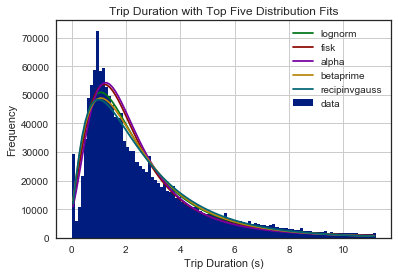

In [14]:
f = plt.figure(figsize=(6,4))

# get the discrete distribution for calculating best-fit distributions
y,x = np.histogram(trip_dist_3sigma, bins=n_bins)
x_mid = (x[1:] + x[:-1]) / 2.

# plot the data as a histogram
ax = trip_dist_3sigma.hist(bins=n_bins, label='data')

# get the top five distributions from fitter
# and plot an area-corrected pdf
plot_dist = fitter_error_df.iloc[:5].index

for dist in plot_dist:
    params = fit.fitted_param[dist]
    
    plot_pdf = eval(dist).pdf(x_mid, *params)
    norm = y.sum() / plot_pdf.sum()
    plot_pdf *= norm
    
    ax.plot(x_mid, plot_pdf, label=dist)

    
_ = ax.set(xlabel='Trip Duration (s)',
           ylabel='Frequency',
           title='Trip Duration with Top Five Distribution Fits')

_ = ax.legend()
f.savefig('fig3_q2.png', dpi=300, transparent=True)

<a id='question3'></a>
## Question 3
[*Return to Introduction*](#introduction)
> * Report mean and median trip distance grouped by hour of day.
> * We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

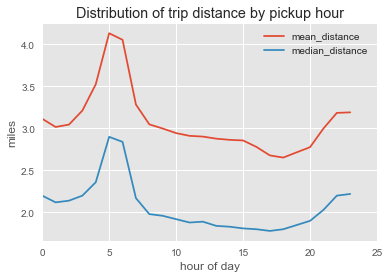

-----Trip distance by hour of the day-----

    hour  mean_distance  median_distance
0      0       3.115276             2.20
1      1       3.017347             2.12
2      2       3.046176             2.14
3      3       3.212945             2.20
4      4       3.526555             2.36
5      5       4.133474             2.90
6      6       4.055149             2.84
7      7       3.284394             2.17
8      8       3.048450             1.98
9      9       2.999105             1.96
10    10       2.944482             1.92
11    11       2.912015             1.88
12    12       2.903065             1.89
13    13       2.878294             1.84
14    14       2.864304             1.83
15    15       2.857040             1.81
16    16       2.779852             1.80
17    17       2.679114             1.78
18    18       2.653222             1.80
19    19       2.715597             1.85
20    20       2.777052             1.90
21    21       2.999189             2.03
22    22     

In [4]:
plt.style.use('ggplot')
# First, convert pickup and drop off datetime variable in their specific righ format
df['pickup_time'] = df['lpep_pickup_datetime'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df['dropoff_time'] = df['Lpep_dropoff_datetime'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a variable for pickup hours
df['pickup_hour'] = df['pickup_time'].apply(lambda x: x.hour)


# Plot -- Mean and Median of trip distance by pickup hour
f, ax = plt.subplots(1,1,figsize=(6,4)) # prepare fig to plot mean and median values by hour
# use a pivot table to group by and aggregate Trip_distance by hour
pivot_tab = df.pivot_table(index='pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
pivot_tab.columns = ['hour','mean_distance','median_distance']
pivot_tab[['mean_distance','median_distance']].plot(ax=ax)
plt.ylabel('miles')
plt.xlabel('hour of day')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([0,25])
plt.savefig('fig1_q3.jpeg',format='jpeg')
plt.show()
print('-----Trip distance by hour of the day-----\n')
print(pivot_tab)

In [5]:
# select airport trips where RateCodeID equals 2(JFK) or 3(N ewwark).
airport_df = df[(df.RateCodeID==2) | (df.RateCodeID==3)]
print("Number of trips to or from NYC airports: ", airport_df.shape[0])
print("Average amount of fare of trips to or from NYC airports: $", airport_df.Fare_amount.mean(),"per trip")
print("Average amount of total charged (before tip) of trips to or from NYC airports: $", airport_df.Total_amount.mean(),"per trip")

Number of trips to or from NYC airports:  5552
Average amount of fare of trips to or from NYC airports: $ 48.976945244956774 per trip
Average amount of total charged (before tip) of trips to or from NYC airports: $ 57.20842038904719 per trip


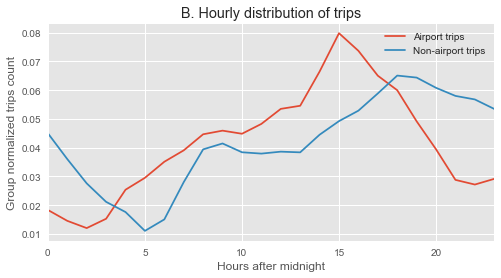

In [23]:
plt.style.use('ggplot')
f, ax = plt.subplots(1,1,figsize = (8,4))

air_dist = airport_df.Trip_distance # airport trips
air_dist = air_dist[~((air_dist-air_dist.median()).abs()>3*air_dist.std())]

airport_df['pickup_hour'].value_counts(normalize=True).sort_index().plot(ax = ax)
df.loc[~df.index.isin(air_dist.index),'pickup_hour'].value_counts(normalize=True).sort_index().plot(ax = ax)
ax.set_xlabel('Hours after midnight')
ax.set_ylabel('Group normalized trips count')
ax.set_title('B. Hourly distribution of trips')
ax.legend(['Airport trips','Non-airport trips'],loc='best')
plt.savefig('fig2_q3.jpeg',format='jpeg')
plt.show()

<a id='question4'></a>
## Question 4
[*Return to Introduction*](#introduction)
> * Build a derived variable for tip as a percentage of the total fare.
> * Build a predictive model for tip as a percentage of the total fare. Use as much of the     data as you like (or all of it). We will validate a sample.

<a id='q4_bike_shift calculation'></a>
### 4.1 Derived variable for tip



In [6]:
df = df[(df.Total_amount>=2.5)] #Initial charge is $2.5
df['tip_pct'] = 100 * df['Tip_amount']/df['Total_amount']
print("Statistics_Summary of Tip percentage")
print('\n')
print(df.tip_pct.describe())


Statistics_Summary of Tip percentage


count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: tip_pct, dtype: float64


### 4.2 Predictive Model

In [25]:
# Reload the data again
base_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
filename = 'green_tripdata_2015-09'


if os.path.exists('green_tripdata_201509.csv'): # if the dataset is present on local path and load it
    df = pd.read_csv('green_tripdata_201509.csv')
else: # Download dataset if not available on current path
    the_url = base_url + filename + '.csv'
    df = pd.read_csv(the_url)
    df.to_csv(the_url.split('/')[-1])

# Print the shape of the dataset
#print("Num of Rows is {} and Num of Columns is {}.".format(df.shape[0], df.shape[1]))

### 4.2.1  Data cleaning

Data processing part includes: 

- Ehail_fee was removed since 99% of the data are missing
- Trip_type missings were replaced with mode value that was 1
- Invalid data were found in:
  - RateCodeID: about 0.01% of the values were 99. These were replaced by the most common value 1
  - Extra: 0.08% of transactions had negative Extra. These were replaced by 0 as the most frequent   
  - Total_amount, Fare_amount, improvement_surcharge, Tip_amount: 0.16% of values were negative. The cases were considered as being machine errors during the data entry. They were replaced by their absolute values.  Furthermore, as the minimum Total_amount that is chargeable for any service is \$2.5, every transaction falling below that amount was replaced by the median value of the Total_amount 11.76.

See code below:

In [17]:
def preprocessing(data):
    """
    This function do data processing:
    . drop Ehail_fee -- 99% transactions are Nan 
    . imputation of missing values in Trip_type
    . replace invalid data by mode for RateCodeID and Extra
    . encode categorical variables
    . rename pickup and dropff time variables (for later use)
    
    input:
        raw_data: pandas.dataframe
    output: 
        pandas.dataframe

    """
    ## make a copy of the input
    data = data.copy()
    ## drop Ehail_fee: 99% of its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)

    ##  replace missing values in Trip_type with the most frequent value 1
    data['Trip_type '] = data['Trip_type '].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    # remove negative values from Total amound and Fare_amount
    print("Negative values found and replaced by their abs")
    print("Total_amount", round(100*data[data.Total_amount<0].shape[0]/float(data.shape[0]), 2),"%")
    print("Fare_amount", round(100*data[data.Fare_amount<0].shape[0]/float(data.shape[0]), 2),"%")
    print("Improvement_surcharge", round(100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]), 2),"%")
    print("Tip_amount", round(100*data[data.Tip_amount<0].shape[0]/float(data.shape[0]), 2),"%")
    print("Tolls_amount", round(100*data[data.Tolls_amount<0].shape[0]/float(data.shape[0]), 2),"%")
    print("MTA_tax", round(100*data[data.MTA_tax<0].shape[0]/float(data.shape[0]), 2),"%")
    data.Total_amount = data.Total_amount.abs()
    data.Fare_amount = data.Fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.Tip_amount = data.Tip_amount.abs()
    data.Tolls_amount = data.Tolls_amount.abs()
    data.MTA_tax = data.MTA_tax.abs()
    
    # RateCodeID
    indices_oi = data[~((data.RateCodeID >= 1) & (data.RateCodeID <= 6))].index
    data.loc[indices_oi, 'RateCodeID'] = 1 # 1 = Standard rate was identified as the common method
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 1")
    
    # Payment_type
    indices_oi = data[~((data.Payment_type >= 1) & (data.Payment_type<= 6))].index
    data.loc[indices_oi, 'Payment_type'] = 2 # 2 = Cash payment was identified as the common method
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Payment were invalid.--> Replaced by the most frequent 2")
    
    # Extra
    indices_oi = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
    data.loc[indices_oi, 'Extra'] = 0 # 0 was identified as the most frequent value
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Extra were invalid.--> Replaced by the most frequent 0")
    
    # Total_amount: the minimum charge is 2.5, so I will replace every thing less than 2.5 by the median 11.76 (pre-obtained in analysis)
    indices_oi = data[(data.Total_amount < 2.5)].index
    data.loc[indices_oi,'Total_amount'] = 11.76
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 1.76")
    
    # encode categorical to numeric (I avoid to use dummy to keep dataset small)
    if data.Store_and_fwd_flag.dtype.name != 'int64':
        data['Store_and_fwd_flag'] = (data.Store_and_fwd_flag=='Y')*1
    
    # rename time stamp variables and convert them to the right format
    print("Converting timestamps variables to right format ...")
  
    data['lpep_pickup_datetime'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Lpep_dropoff_datetime'] = data.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    
    print("Renaming variables...")
    data.rename(columns = {'lpep_pickup_datetime':'Pickup_dt', 'Lpep_dropoff_datetime':'Dropoff_dt'}, inplace=True)
    
    print("Done cleaning")
    return(data)

In [18]:
data = preprocessing(df)

Negative values found and replaced by their abs
Total_amount 0.0 %
Fare_amount 0.0 %
Improvement_surcharge 0.0 %
Tip_amount 0.0 %
Tolls_amount 0.0 %
MTA_tax 0.0 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 1
0.0 % of values in Payment were invalid.--> Replaced by the most frequent 2
0.0 % of values in Extra were invalid.--> Replaced by the most frequent 0
0.0 % of values in total amount worth <$2.5.--> Replaced by the median 1.76
Converting timestamps variables to right format ...
Renaming variables...
Done cleaning


In [10]:
data.shape

(1487767, 24)

### 4.2.2 Feature Engineering

During this step, I intuitively created new varibles derived from current variables.

The models below could be improved in the following ways **(TODO)**:

> * adding data from the weekends, in addition to a boolean feature denoting weekday/weekend and other variables like Hour (hour of day), Shift_type (shift period of the day) and Trip_duration.
> * addition of other features such as holidays
> * adding trip directions: Direction_NS (is the cab moving Northt to South) and Direction_EW (is the cab moving East to West). 
> * adding speed which is the ratio of Trip_distance to Trip_duration. 

> * with_tip: This is to identify transactions with tips or not. This variable was created after discovering that 60% of transactions have 0 tip.



In [19]:
# Function to run the feature engineering
def feature_engineering(data):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . shift_or_not type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day  
    . speed_avg: float, speed of the trip
    . tip_pct: float, target variable
    . tip_or_not: int {0,1}, 1 = transaction with tip, 0 transction without tip
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = data.copy()
    
    # derive time variables
    print( "deriving time variables...")
    ref_week = dt.datetime(2015,9,1).isocalendar()[1] # first week of september in 2015
    data['Week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week+1
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
    #data.rename(columns={'Pickup_hour':'Hour'},inplace=True)

    # create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
    data['shift_or_not'] = None
    data.loc[data[(data.Hour>=7) & (data.Hour<15)].index, 'shift_or_not'] = 1
    data.loc[data[(data.Hour>=15) & (data.Hour<23)].index, 'shift_or_not'] = 2
    data.loc[data[data.shift_or_not.isnull()].index, 'shift_or_not'] = 3
    
    # Trip duration 
    print( "deriving Trip_duration...")
    data['trip_duration'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    print( "deriving direction variables...")
    # create direction variable Direction_NS. 
    # This is 2 if taxi moving from north to south, 1 in the opposite direction and 0 otherwise
    data['Direction_NS'] = (data.Pickup_latitude > data.Dropoff_latitude)*1+1
    indices = data[(data.Pickup_latitude == data.Dropoff_latitude) & (data.Pickup_latitude!=0)].index
    data.loc[indices,'Direction_NS'] = 0

    # create direction variable Direction_EW. 
    # This is 2 if taxi moving from east to west, 1 in the opposite direction and 0 otherwise
    data['Direction_EW'] = (data.Pickup_longitude>data.Dropoff_longitude)*1+1
    indices = data[(data.Pickup_longitude == data.Dropoff_longitude) & (data.Pickup_longitude!=0)].index
    data.loc[indices,'Direction_EW'] = 0
    
    # create variable for Speed
    print("deriving Speed. Make sure to check for possible NaNs and Inf vals...")
    data['speed_avg'] = data.Trip_distance/(data.trip_duration/60)
    # replace all NaNs values and values >240mph by a values sampled from a random distribution of 
    # mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution
    indices_oi = data[(data.speed_avg.isnull()) | (data.speed_avg>240)].index
    data.loc[indices_oi,'speed_avg'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
    print("Feature engineering done! :-)")
    
    # Create a new variable to check if a trip originated in Upper Manhattan

    # create tip percentage variable
    data['tip_pct'] = 100*data.Tip_amount/data.Total_amount
    
    # create with_tip variable
    data['tip_or_not'] = (data.tip_pct>0)*1

    return(data)

In [20]:
print( "size before feature engineering:", data.shape)
df_= feature_engineering(data)
print( "size after feature engineering:", data.shape)

size before feature engineering: (1487767, 24)
deriving time variables...
deriving Trip_duration...
deriving direction variables...
deriving Speed. Make sure to check for possible NaNs and Inf vals...
Feature engineering done! :-)
size after feature engineering: (1487767, 24)


### 4.2.3 Exploratory Data Analysis
> * Correlation plots between X variables and Y targeted variable -- 'tip percent(tip_pct)'. 
> * Create a binary Y predicted variable --"tip_or_not" of 1 (if there is tip) and 0 (otherwise) was created.
> * Create regression model for transaction with non-zero tip 



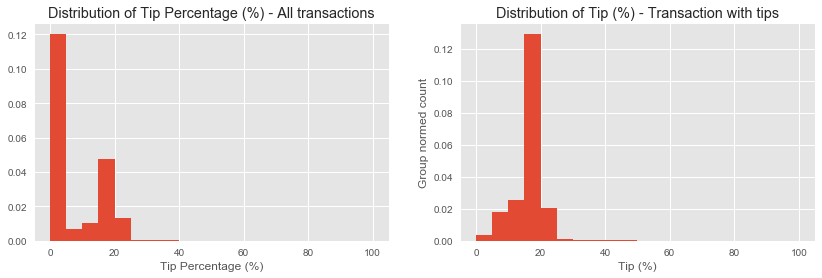

In [94]:
data = df_.copy()
## code to compare the two Tip_percentage identified groups

data1 = data[data.tip_pct > 0]
data2 = data[data.tip_pct == 0]

# generate histograms to compare
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(14,4))
ax = ax1
data.tip_pct.hist(bins = 20, normed=True, ax = ax)
ax.set_xlabel('Tip Percentage (%)')
ax.set_title('Distribution of Tip Percentage (%) - All transactions')

ax = ax2
data1.tip_pct.hist(bins = 20,normed=True, ax = ax)
ax.set_xlabel('Tip (%)')
ax.set_title('Distribution of Tip (%) - Transaction with tips')
ax.set_ylabel('Group normed count')
plt.savefig('fig1_q4.jpeg',format='jpeg')
plt.show()

In [79]:
def fare_t_test(df,label,yl=[0,50]):
    """
    This function test if the means of the two groups with_tip and without_tip are different at 95% of confidence level.
    It will also generate a box plot of the variable by tipping groups
    label: str, label to test
    yl: tuple or list (default = [0,50]), y limits on the ylabel of the boxplot
    df: pandas.DataFrame (default = data)
    
    Example: run <visualize_continuous(data,'Fare_amount',outlier='on')>
    """
    
    if len(pd.unique(df[label]))==2: #check if the variable is categorical with only two  categores and run chisquare test
        vals=pd.unique(df[label])
        gp1 = df[df.tip_or_not ==0][label].value_counts().sort_index()
        gp2 = df[df.tip_or_not==1][label].value_counts().sort_index()
        print( "t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print( chisquare(gp1,gp2) )
    elif len(pd.unique(df[label]))>=10: #other wise  run the t-test
        df.boxplot(label,by='tip_or_not')
        plt.ylim(yl)
        plt.savefig('fig2_q4.jpeg',format='jpeg')
        plt.show()
        print( "t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print("results:",ttest_ind(df[df.tip_or_not==0][label].values, df[df.tip_or_not==1][label].values))
    else:
        pass


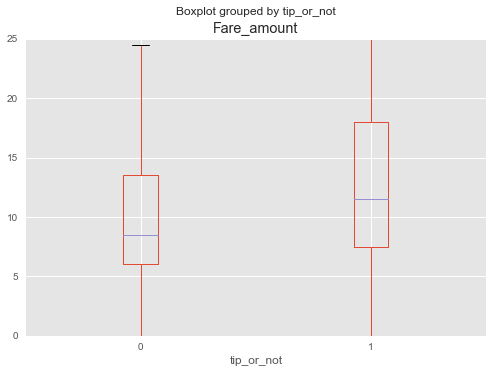

t-test if Fare_amount can be used to distinguish transaction with tip and without tip
results: Ttest_indResult(statistic=-167.00096498871079, pvalue=0.0)


In [34]:
fare_t_test(data,'Fare_amount', [0,25])

### 4.2.4  Building the Model
As explained in the previous section, this model will be a combination of rules from two models 
> * Part 1: The classification model to classify a transaction into a tipper (=1) or not (=0)and 
First of all, functions for cross-validation and parameter optimization were defined such that they can be used on either classification or regression algorithm
> * Part 2: Regression model to estimate the percentage of the tip given that the results from the classification model was 1


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
from sklearn.model_selection import train_test_split
from 

## Part 1: Classification Model
### 4.2.4.1 Ensembling & Stacking models
Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble!

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

**Creating NumPy arrays out of our train and test sets**

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [22]:
data = df_.copy()
train, test = train_test_split(data, test_size=0.3, random_state=42)
Xcol = ['Payment_type','Total_amount','trip_duration','speed_avg','MTA_tax',
        'Extra','Hour','Direction_NS', 'Direction_EW']
Xtrain = train[Xcol].values
Ytrain = train['tip_or_not'].ravel()
Xtest  = test[Xcol].values
Ytest  = test['tip_or_not'].ravel()


In [23]:
# Some useful parameters which will come in handy later on
ntrain = Xtrain.shape[0]
ntest = Xtest.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=42)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

#### Out-of-Fold Predictions

- Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [24]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### 4.2.4.2 Generating our Base First-Level Models
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

- Random Forest classifier
- AdaBoost classifer 
- Gradient Boosting classifer

More models I want to use if have enough time:
> * Logistics classifier
> * Extra Trees classifier
> * Support Vector Machine



**Parameters**

Just a quick summary of the parameters that we will be listing here for completeness,

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high  a number would run the risk of overfitting as one would be growing the tree too deep

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with. 

In [27]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params = rf_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)


Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [28]:
start = dt.time()
rf_oof_train, rf_oof_test = get_oof(rf, Xtrain, Ytrain, Xtest) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, Xtrain, Ytrain, Xtest) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, Xtrain, Ytrain, Xtest) # Gradient Boost




**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [30]:
# #Be patient, it takes around 6hrs to end this step.

rf_feature = rf.feature_importances(Xtrain, Ytrain)
ada_feature = ada.feature_importances(Xtrain, Ytrain)
gb_feature = gb.feature_importances(Xtrain, Ytrain)


Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [31]:
rf_features = [  8.63999734e-01,   9.15139863e-02,   2.98632986e-02,   4.74048791e-03,\
   7.22330964e-03,   6.15364312e-04,   3.59667557e-04,   4.69010305e-05, 1.63725031e-03]
ada_features = [0.004,  0.434,  0.318,  0.178,  0.018,  0.012,  0.01,   0.01,   0.016]
gb_features = [ 0.26770981,  0.30861396,  0.26005993,  0.11586234,  0.02772109,  0.01165811,\
  0.00527926,  0.0014325,   0.00166298]   



**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers  via a plotly scatter plot by calling "Scatter" as follows:

In [33]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# Scatter plot 
import plotly.graph_objs as go
cols = Xcol
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig2_q4')


# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig3_q4')


# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig4_q4')

In [34]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(4)

,AdaBoost feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.004,0.267710,0.864000,Payment_type,0.378570
1,0.434,0.308614,0.091514,Total_amount,0.278043
2,0.318,0.260060,0.029863,trip_duration,0.202641
3,0.178,0.115862,0.004740,speed_avg,0.099534


** Plotly Barplot of Average Feature Importances **

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [35]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
            y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')
#py.image.ishow(fig)

### Second-Level Predictions from the First-level Output

In [39]:
x_train = np.concatenate(( rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.


#### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [40]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
     n_estimators= 500,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread= -1,
     scale_pos_weight=1).fit(x_train, Ytrain)
Ypred = gbm.predict(x_test)


Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

- Results:
> * It looks like a pretty good binary classifer. The accuracy is 98.26%, Roc-Auc score is 0.98. 

In [42]:
print('The accuracy of our model is', metrics.accuracy_score(Ypred, Ytest))


The accuracy of our model is 0.982598116644


In [43]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Ytest, Ypred)
metrics.auc(fpr, tpr)

0.98320371058785994

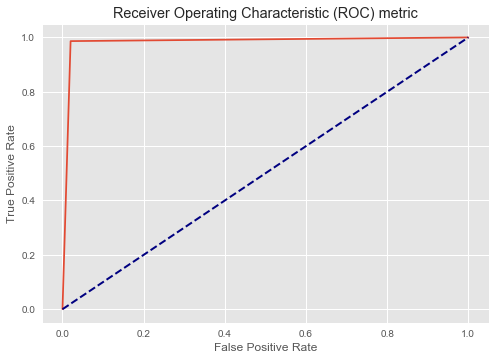

In [44]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) metric')
plt.legend(loc="lower right")
plt.show()

## Part 2:  Regression Model

In the section of code below, I essentially write a class SklearnHelper that is similiar to what I did in classification part, except the parameters of 'classification' changed to 'regressison' and evaluation methods changed to 'MSE', 'Chi^2' and 'R^2'.

The result of those metrics looks nice. MSE = 14.94, Chi2's p_value equals 0 which means there is the linear relationship between the predictors and fitted values, and  R^2 = 0.82.

In [ ]:
data = df_.copy()
train, test = train_test_split(data, test_size=0.3, random_state=42)
Xcol = ['Payment_type','Total_amount','trip_duration','speed_avg','MTA_tax',
        'Extra','Hour']
Xtrain = train[Xcol].values
Ytrain = train['tip_pct'].ravel()
Xtest  = test[Xcol].values
Ytest  = test['tip_pct'].ravel()


In [50]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params = rf_params)
ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)


rf_oof_train, rf_oof_test = get_oof(rf, Xtrain, Ytrain, Xtest) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, Xtrain, Ytrain, Xtest) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, Xtrain, Ytrain, Xtest) # Gradient Boost


rf_feature = rf.feature_importances(Xtrain, Ytrain)
ada_feature = ada.feature_importances(Xtrain, Ytrain)
gb_feature = gb.feature_importances(Xtrain, Ytrain)


In [53]:
rf_features = [ 0.77708396,  0.11586995,  0.06352566,  0.02121415,  0.0111805,   0.00281868,
  0.0083071]
ada_features = [0.31196701,  0.20739182,  0.24449121,  0.09351292,  0.04863248,  0.,
  0.09400456]
gb_features = [ 0.15297513,  0.29911202,  0.26261004,  0.20287461,  0.01136884,  0.01387613,
  0.05718323]   

In [54]:
x_train = np.concatenate(( rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

In [56]:
import xgboost as xgb
gbm = xgb.XGBRegressor(
    #learning_rate = 0.02,
     n_estimators= 500,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'reg:linear',
     nthread= -1,
     scale_pos_weight=1).fit(x_train, Ytrain)
Ypred = gbm.predict(x_test)



In [57]:
from sklearn.metrics import mean_squared_error
from scipy.stats import chisquare
from sklearn import metrics
mse = mean_squared_error(Ytest, Ypred)
chi2 = chisquare(Ytest, Ypred, ddof=1)
r2 = metrics.r2_score(Ytest, Ypred)

In [64]:
print('MSE = {}, Chi2 stat is {} and R^2 = {}'. format(mse, chi2, r2))

MSE = 14.940090574081065, Chi2 stat is Power_divergenceResult(statistic=202262.35234212157, pvalue=0.0) and R^2 = 0.8166294155176195


## Question 5
- Option A: Distributions
> * Build a derived variable -- 'speed_avg' representing the average speed over the course of a trip.
> * Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?
**Pairwise t-test**
> * Can you build up a hypothesis of average trip speed as a function of time of day? ** One-Way ANOVA Test **

- Steps and Results:
> * Perform pairwise t-test based on 'speed_avg' on different weeks.
> * Null hypothesis: speed_avg from week_i = speed_avg from week_j
> * Results: We will see that the speed is not really different in all weeks. From the hypothesis test, we see that we don’t have enough evidence to reject null hypothesis since  speeds are different in Week 2 and Week 3 are significantly different hence we fail to reject the null hypothesis at 95% level of confidence. The rest of the weeks have smaller p-values, so we can reject the null hypothesis and say that they are significantly different. 

mean speed by week:
       speed_avg
Week           
1     13.372710
2     12.699719
3     12.696008
4     13.173098
5     12.507190


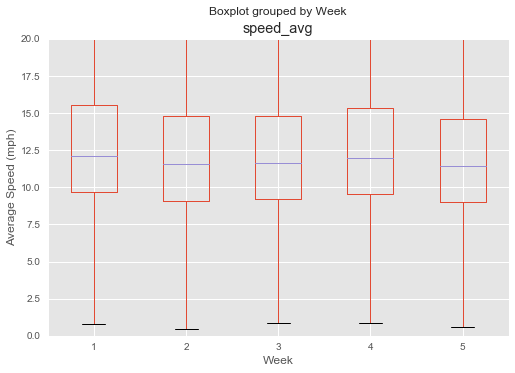

p-values:
 w1              1              2              3              4              5
w2                                                                           
1    1.000000e+00   0.000000e+00   0.000000e+00   1.289299e-29  6.135456e-305
2    0.000000e+00   1.000000e+00   8.185778e-01  8.895309e-178   4.796312e-18
3    0.000000e+00   8.185778e-01   1.000000e+00  1.122881e-184   4.949789e-18
4    1.289299e-29  8.895309e-178  1.122881e-184   1.000000e+00  1.799634e-193
5   6.135456e-305   4.796312e-18   4.949789e-18  1.799634e-193   1.000000e+00


In [45]:
data = df_.copy()
print("mean speed by week:\n", data[['speed_avg','Week']].groupby('Week').mean())
# generate boxplot
data.boxplot('speed_avg','Week')
plt.ylim([0,20]) # cut off outliers
plt.ylabel('Average Speed (mph)')
plt.show()

# calculate t-test
weeks = pd.unique(data.Week)
pvals = []
for i in range(len(weeks)): # for each pair, run t-test
    for j in range(len(weeks)):
        pvals.append((weeks[i], weeks[j],ttest_ind(data[data.Week==weeks[i]].speed_avg,data[data.Week==weeks[j]].speed_avg)[1]))
    
pvalues = pd.DataFrame(pvals,columns=['w1','w2','pval'])
print("p-values:\n",pvalues.pivot_table(index='w1',columns='w2',values='pval').T)

- Steps and Results:
> * Perform One-Way ANOVA Test on the speed from different hours of the day.
> * Null hypothesis: speed_avg from hour_0 = speed_avg from hour_1 =...=  speed_avg from hour_23
> * Results:  We find that the speed is different in different hours with a zero pvalue of the anova test. The boxplot reveals that traffic is faster early morning and gets really slow in the evening.

one way anova test: F_onewayResult(statistic=3426.4853352812088, pvalue=0.0)


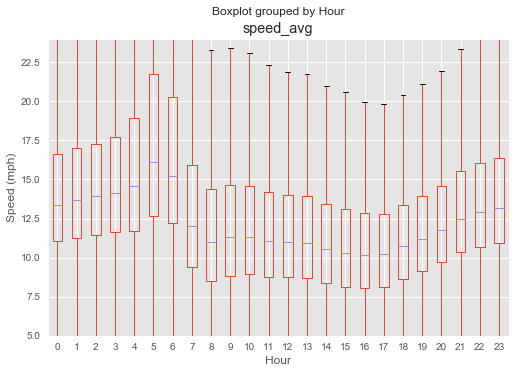

In [47]:
# calculate anova
import matplotlib.pyplot as plt
hours = range(24)
cmd = "f_oneway("
for h in hours:
    cmd+="data[data.Hour=="+str(h)+"].speed_avg,"
cmd=cmd[:-1]+")"
print( "one way anova test:", eval(cmd)) #evaluate the command and print)

# boxplot
data.boxplot('speed_avg','Hour')
plt.ylim([5,24]) # cut off outliers
plt.ylabel('Speed (mph)')
plt.show()



**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.
 3. Use more relevant data, like whole year data in Big Data tools.
 4. Do visualization, like map heat.
 5. Utilize geometry features of map position from longitude and latitude data to build more fancy map plots or create features based on different boroughs.